In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import copy
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.models as models
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset
from torcheval.metrics.functional import multiclass_confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [5]:
df = pd.read_csv('small_train_csv')
df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0.2'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21064 entries, 0 to 21063
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class_label     21064 non-null  object
 1   severity_label  21064 non-null  object
 2   job             21064 non-null  int64 
 3   frame           21064 non-null  int64 
 4   validated       21064 non-null  bool  
 5   file_name       21064 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 843.5+ KB


In [6]:
rare_classes = ["crack_alligator_area", "crack_reflection", "pothole", "raveling"]

In [7]:
df_rare_classes = df[df.class_label.isin(rare_classes)]

In [20]:
train_df = pd.read_csv('small_train_csv')
val_df = pd.read_csv('val_data_csv')

In [23]:
labels_dict = {"crack_alligator_area": 0, "crack_longitudinal": 1, "crack_reflection": 2, 
               "crack_transversal": 3, "patches": 4, "pothole": 5, "raveling": 6}
inv_labels_dict = {v: k for k, v in labels_dict.items()}

class CustomDataset(Dataset):
    def __init__(self, root_dir: str, labels: pd.Series, names: pd.Series, transform=None):
        super().__init__()
        self.data = []
        self.transform = transform
        self.root_dir = root_dir
        img_files = [(label, os.path.join(root_dir, name)) for 
                     name, label in zip(names, labels)]
        self.data.extend(img_files)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][1]
        label = self.data[index][0]
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"] 
            
        return image, labels_dict[label]



#### create transforms for different augmentations of data

In [10]:
data_transforms = {
    'r_class': A.Compose([
    A.Rotate(always_apply=True, limit=(-90, 90)),
    A.ColorJitter(always_apply=True, brightness=(0.8, 1.5), 
                  contrast=(0.8, 2), saturation=(0.8, 1.5), hue=(-0.2, 0.2)),    
    A.Perspective(always_apply=True, scale=(0.05, 0.5), keep_size=0),
    A.Emboss(always_apply=True, alpha=(0.2, 0.4), strength=(0.2, 5.0)),
    A.GridDistortion(always_apply=True, num_steps=7),
    A.Resize(p=1.0, height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()    
        ]),
    'train': A.Compose([    
    A.HorizontalFlip(p=0.5),
    A.CLAHE(clip_limit=(1, 20)),
    A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 29)),
    A.ToGray(always_apply=False, p=0.5),
    A.GridDistortion(always_apply=False, p = 0.5, num_steps=5),
    A.Perspective(always_apply=False, p = 0.5, scale=(0.05, 0.5), keep_size=0),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(p=1.0, height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(p=1.0, height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])
}

In [21]:
train_dataset_small = CustomDataset(root_dir ='crops/small', labels = train_df['class_label'], names = train_df['file_name'],
                             transform = data_transforms['train'])
val_dataset_small = CustomDataset(root_dir ='crops/small', labels = val_df['class_label'], names = val_df['file_name'],
                             transform = data_transforms['val'])

In [11]:
r_class_dataset_medium = CustomDataset(root_dir ='crops/medium', labels = df_rare_classes['class_label'], names = df_rare_classes['file_name'],
                             transform = data_transforms['r_class'])
r_class_dataset_small = CustomDataset(root_dir ='crops/small', labels = df_rare_classes['class_label'], names = df_rare_classes['file_name'],
                             transform = data_transforms['r_class'])

#### show transforms effect on images for different data samples

In [17]:
def visualize_augmentations(dataset, idx=65, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    
    for i in range(samples):
        image, j = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    print(inv_labels_dict[j])

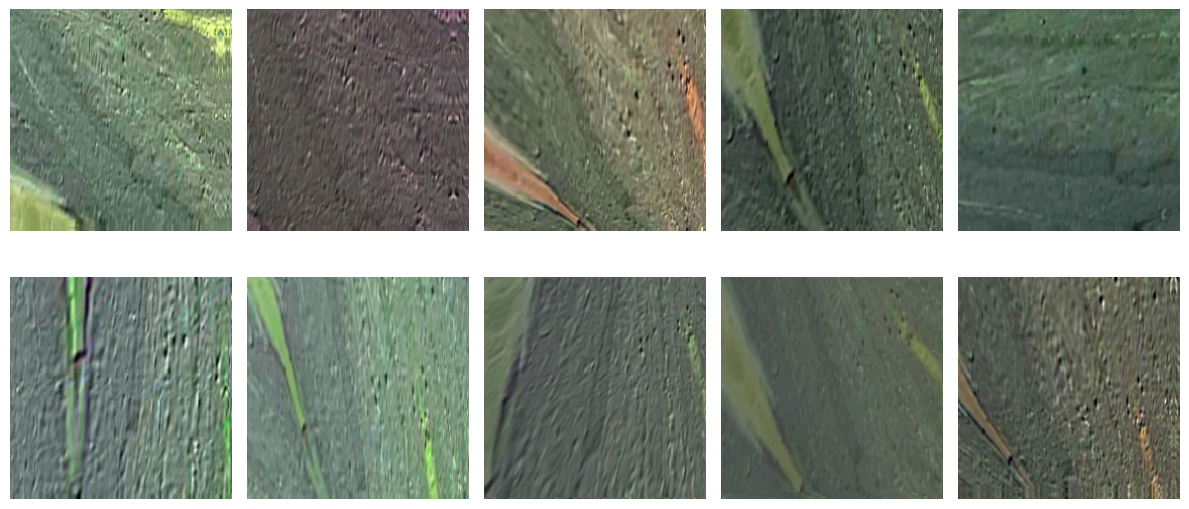

raveling


In [18]:
visualize_augmentations(r_class_dataset_small)

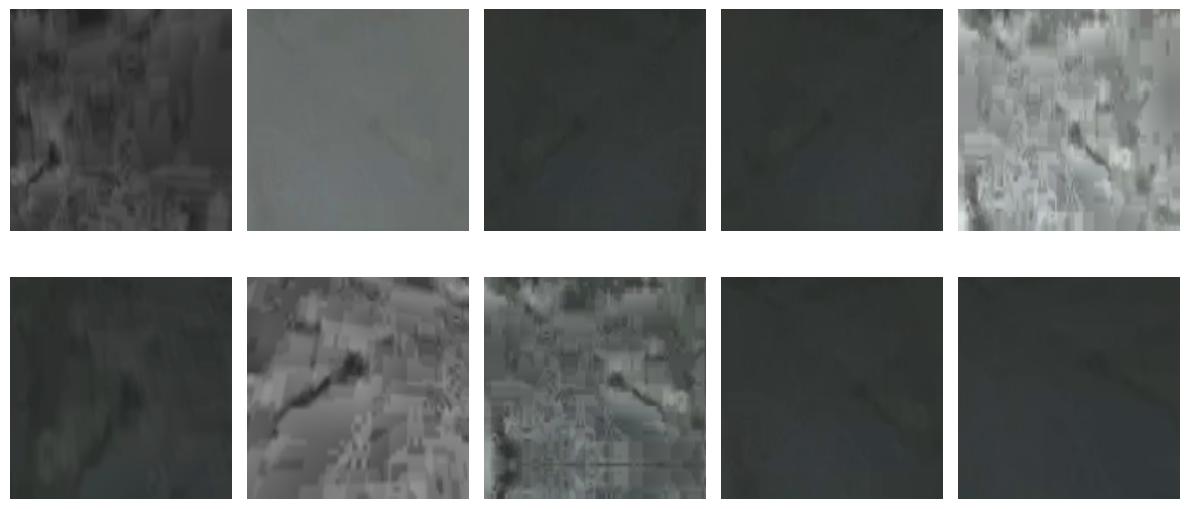

crack_longitudinal


In [25]:
visualize_augmentations(train_dataset_small, idx = 5)

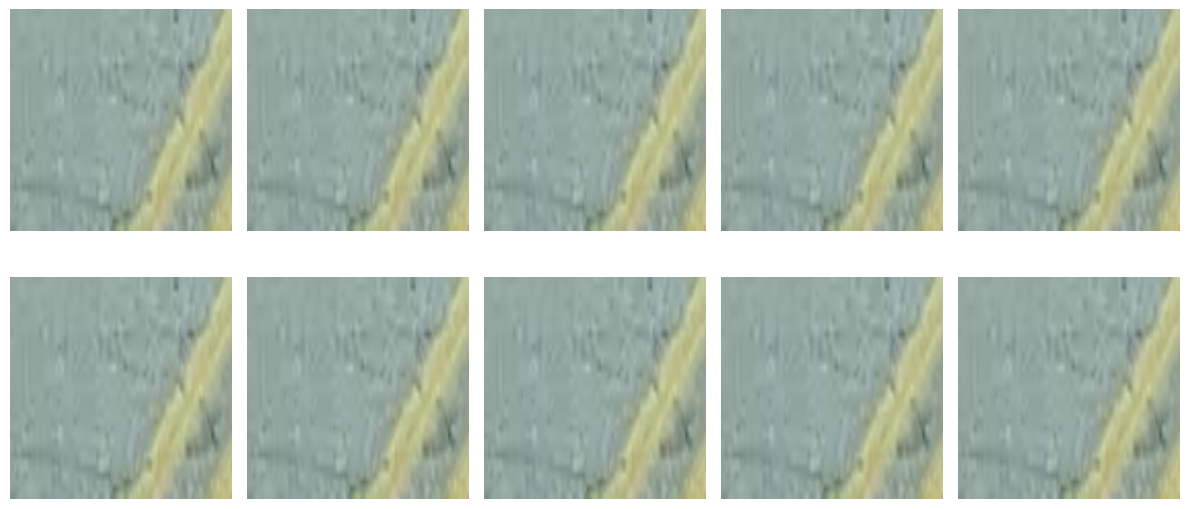

crack_longitudinal


In [27]:
visualize_augmentations(val_dataset_small, idx = 10)